In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install spikingjelly
import torch
import torch.nn as nn
import spikingjelly
import torchvision
import torch.utils.data as data
from tqdm import tqdm
from spikingjelly.activation_based import neuron, layer, learning, surrogate, encoding, functional
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
import matplotlib.pyplot as plt
import numpy as np


transform2 = Compose([
    ToTensor(),
    #Normalize((0.1307,), (0.3081,)),
    Lambda(lambda x: torch.flatten(x))])
data_dir = './data'
device = 'cuda:0'
b = 500
j = 2
train_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=True,
    transform=transform2,
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=False,
    transform=transform2,
    download=True
)

train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=b,
    shuffle=True,
    drop_last=False,
    num_workers=j,
    pin_memory=True
)
test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=b,
    shuffle=True,
    drop_last=False,
    num_workers=j,
    pin_memory=True
)

In [2]:
class LayerOfLain():

  """
  This class is used to instantiate the layer object in the SFF algorithm,
  provide a training function that is uniformly called by the network during training,
  and perform local training independently.

  Member variables:
  threshold_pos (float): used to determine whether goodness_pos is large enough and directly participate in training.
  threshold_neg (float): used to determine whether goodness_neg is small enough and directly participate in training.
  min_weight (float): Used to provide a hard bound when calling the STDP module.
  max_weight (float): Used to provide a hard bound when calling the STDP module.
  encoder (encoder): Poisson encoder, which converts traditional data into pulse shape data that conforms to Poisson distribution.
  time_step (int): The time step length of the simulation for each data sample.
  learning_rate (float): learning rate.
  pre_time_au (float): Spiking neural network hyperparameters, time constants related to membrane potential decay and STDP.
  post_time_au (float): spiking neural network hyperparameters, time constants related to membrane potential decay and STDP.
  learner (MSTDPLearner): reward-modulated STDP learner, called when the STDP module of SFF is started.
  """

  def __init__(self, N_input, N_output, pre_time_au = 2.,
               post_time_au = 100., time_step = 50,
               batch_size = 500, learning_rate = 0.0003, threshold_both = 0.05):
    self.single_net = nn.Sequential(
        layer.Linear(N_input, N_output, bias=False),
        neuron.IFNode(surrogate_function=surrogate.ATan())
    ).to(device)
    self.threshold_pos = threshold_both
    self.threshold_neg = threshold_both
    self.min_weight = -1.
    self.max_weight = 1.
    self.encoder = encoding.PoissonEncoder()
    self.time_step = time_step
    self.learning_rate = learning_rate
    self.pre_time_au = pre_time_au
    self.post_time_au = post_time_au
    self.batch_size = batch_size
    self.N_output = N_output
    self.encoder = encoding.PoissonEncoder()
    self.learner = learning.MSTDPLearner(step_mode='s', batch_size=self.batch_size,
                     synapse=self.single_net[0], sn=self.single_net[1],
                     tau_pre=self.pre_time_au, tau_post=self.post_time_au,
                     )
    self.learner.disable()

  def goodness_cal(self, output):
    goodness = output.pow(2).mean(1)
    #print(goodness)
    return goodness

  def reward_from_goodness(self, output, pos_flag):
    alpha_pos = 1.
    alpha_neg = 1.
    goodness = output.pow(2).mean(1)
    if(pos_flag==True):
      return alpha_pos * (goodness - self.threshold_pos)
    else:
      return alpha_neg * (self.threshold_neg - goodness)


  def forward_with_training(self, input_pos, input_neg, insight_pos, insight_neg, stdpflag = True):

    weight_opter_stdp = torch.optim.SGD(self.single_net.parameters(), lr=0.01, momentum=0.)
    weight_opter_surrogate = torch.optim.Adam(self.single_net.parameters(), lr=self.learning_rate)
    if(stdpflag == True):
      with torch.no_grad():
          self.learner.enable()
          reward_pos = 0.
          for t in range(self.time_step):
              # Positive update
              reward_pos = self.reward_from_goodness(self.single_net(input_pos[t]), True)

              weight_opter_stdp.zero_grad()
              self.learner.step(reward_pos, on_grad=True)
              weight_opter_stdp.step()
          self.learner.reset()

          reward_neg = 0.
          for t3 in range(self.time_step):
              # Negative update
              reward_neg = self.reward_from_goodness(self.single_net(input_neg[t3]), False)

              weight_opter_stdp.zero_grad()
              self.learner.step(reward_neg, on_grad=True)
              weight_opter_stdp.step()
          self.learner.reset()
          torch.cuda.empty_cache()
          self.learner.disable()
      functional.reset_net(self.single_net)
      torch.cuda.empty_cache()

    goodness_pos = 0.
    for t in range(self.time_step):
        # Positive update
        #print(input_pos.max())
        goodness_pos += self.goodness_cal(self.single_net(input_pos[t]))

    goodness_pos = goodness_pos / self.time_step

    goodness_neg = 0.
    for t3 in range(self.time_step):
        # Negative update
        goodness_neg += self.goodness_cal(self.single_net(input_neg[t3]))

    goodness_neg = goodness_neg / self.time_step

    combined_pos = self.threshold_pos - goodness_pos - insight_pos
    combined_neg = - self.threshold_neg + goodness_neg - insight_neg

    loss_mixed = torch.log(torch.exp(torch.cat([combined_pos, combined_neg])) + 1).mean()
    weight_opter_surrogate.zero_grad()
    loss_mixed.backward()
    weight_opter_surrogate.step()
    functional.reset_net(self.single_net)

  def forward_withOUT_training(self, input_pos, input_neg):
    total_output_pos_list = []
    total_output_neg_list = []
    for t2 in range(self.time_step):
      total_output_pos_list.append((self.single_net(input_pos[t2])).detach())
      total_output_neg_list.append((self.single_net(input_neg[t2])).detach())

    total_output_pos = torch.stack(total_output_pos_list, dim=0)
    total_output_neg = torch.stack(total_output_neg_list, dim=0)
    return total_output_pos, total_output_neg

  def forward_withOUT_training_single(self, input_pos, firstflag):
    total_output_pos_list = []
    if(firstflag==0):
      for t2 in range(self.time_step):
        total_output_pos_list.append(self.single_net(input_pos[t2]).detach())
      total_output_pos = torch.stack(total_output_pos_list, dim=0)
    else:
      for t2 in range(self.time_step):
        total_output_pos_list.append(self.single_net(input_pos[t2]).detach())
      total_output_pos = torch.stack(total_output_pos_list, dim=0)


    return total_output_pos

In [3]:
def label_encoder(input, label):
    labeled_input = input.clone()
    labeled_input[:, :10] *= 0.0
    labeled_input[range(input.shape[0]), label] = 1.0
    labeled_input[:, -28:-18] *= 0.0
    labeled_input[range(input.shape[0]), -28+label] = 1.0
    return labeled_input

def poisson_iter(input, t):
    batch_size, dim = input.shape
    output = torch.zeros((t, batch_size, dim))
    encoder = encoding.PoissonEncoder()
    for i in range(t):
        encoden_input = encoder(input)
        output[i] = encoden_input
    return output

class NetOfLain(torch.nn.Module):

    """
    This class is used to instantiate the net object in the SFF algorithm, coordinate and call the training functions of each layer during training, so that they can perform local training independently.

    Member variables:
    lain_layers (LayerOfLain list): used to store layers for constructing SFF spiking neural network.
    insight_pos (float): The key constant for SFF to realize layer collaboration, which is the sum of the goodness of each layer after positive data propagation.
    """

    def __init__(self, lain_dimension):
        super().__init__()
        self.lain_layers = []
        self.insight_pos = 0.
        self.insight_neg = 0.
        for d in range(len(lain_dimension) - 1):
            if(d == 0):
              layer = LayerOfLain(lain_dimension[d], lain_dimension[d + 1], pre_time_au = 2., post_time_au = 100.)
              self.lain_layers.append(layer)
            else:
              layer = LayerOfLain(lain_dimension[d], lain_dimension[d + 1], pre_time_au = 2., post_time_au = 100., learning_rate = 0.004, threshold_both=0.04)
              self.lain_layers.append(layer)

    def network_train_layers(self, train_data_loader, epo):
      torch.cuda.empty_cache()
      for i, lain_layer in enumerate(self.lain_layers):
        print('training layer', i, '...')
        for features, labels in tqdm(train_data_loader):
          #if(epo > i*1):
            #break
          torch.cuda.empty_cache()
          features, labels = features.to(device), labels.to(device)
          features_pos = label_encoder(features, labels)
          rnd = torch.randperm(features.size(0))
          features_neg = label_encoder(features, labels[rnd])
          features_pos = poisson_iter(features_pos, lain_layer.time_step)
          features_pos = features_pos.to(device)
          features_neg = poisson_iter(features_neg, lain_layer.time_step)
          features_neg = features_neg.to(device)
          del features, labels
          torch.cuda.empty_cache()
          #features_pos = features_pos.transpose(0, 1)
          #features_neg = features_neg.transpose(0, 1)
          self.insight_pos = self.network_collaboration(features_pos)
          self.insight_neg = self.network_collaboration(features_neg)
          positive_hidden, negative_hidden = features_pos, features_neg
          if(i > 0) :
            for o in range(i):
              positive_hidden, negative_hidden = self.lain_layers[o].forward_withOUT_training(positive_hidden, negative_hidden)
              functional.reset_net(self.lain_layers[o].single_net)
          torch.cuda.empty_cache()
          if(i==0):
            lain_layer.forward_with_training(positive_hidden, negative_hidden, self.insight_pos, self.insight_neg, stdpflag=False)
          else:
            lain_layer.forward_with_training(positive_hidden, negative_hidden, self.insight_pos, self.insight_neg, stdpflag=True)

    def network_predict(self, input):
      every_labels_goodness = []
      for label in range(10):
        hidden = label_encoder(input, label)
        hidden = poisson_iter(hidden, 50)
        hidden = hidden.to(device)
        torch.cuda.empty_cache()
        every_layer_goodness = []
        for p, lain_layer in enumerate(self.lain_layers):
          hidden = lain_layer.forward_withOUT_training_single(hidden, p)
          goodnesstem = []
          for t in range(lain_layer.time_step):
            goodnesstem.append((hidden[t].pow(2).mean(1)).unsqueeze(0))
          every_layer_goodness += [(torch.cat(goodnesstem, dim=0)).sum(0)]
        every_labels_goodness += [sum(every_layer_goodness).unsqueeze(1)]
        del hidden
        #for lain_layer in self.lain_layers:
          #functional.reset_net(lain_layer.single_net)
        torch.cuda.empty_cache()
      every_labels_goodness = torch.cat(every_labels_goodness, 1)
      return every_labels_goodness.argmax(1)

    def network_collaboration(self, input):
        hidden = input.clone()
        every_layer_goodness = []
        for p, lain_layer in enumerate(self.lain_layers):
          hidden = lain_layer.forward_withOUT_training_single(hidden, p)
          goodnesstem = []
          for t in range(lain_layer.time_step):
            goodnesstem.append((hidden[t].pow(2).mean(1)).unsqueeze(0))
          every_layer_goodness += [(torch.cat(goodnesstem, dim=0)).sum(0)]
          functional.reset_net(lain_layer.single_net)
        del hidden
        torch.cuda.empty_cache()
        return sum(every_layer_goodness)

STDP: ON
Epoch: 1
training layer 0 ...


100%|██████████| 120/120 [01:07<00:00,  1.78it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.09949995875358582
Epoch: 1
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.05it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.24309996664524078
Epoch: 2
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.5140999764204025
Epoch: 1
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.06it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.8831999946385622
Epoch: 2
training layer 0 ...


100%|██████████| 120/120 [00:59<00:00,  2.00it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.8873999949544669


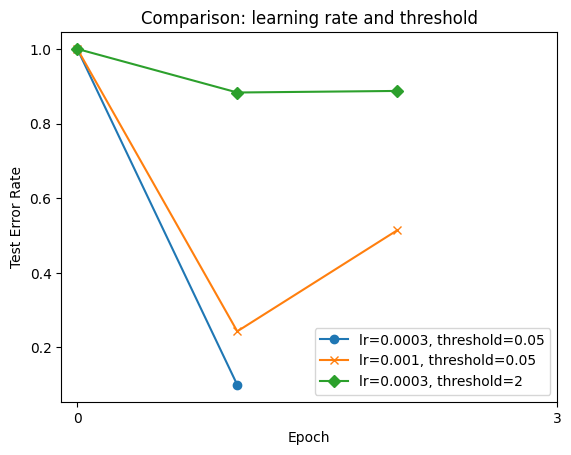

Epoch: 1
training layer 0 ...


100%|██████████| 120/120 [00:59<00:00,  2.00it/s]


training layer 1 ...


100%|██████████| 120/120 [02:43<00:00,  1.37s/it]


test error: 0.4605999648571014
Epoch: 2
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:43<00:00,  1.36s/it]


test error: 0.4986999735236168
Epoch: 3
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.05it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.5324999794363976
Epoch: 4
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.4980999708175659
Epoch: 5
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.06it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.4670999750494957
Epoch: 6
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.05it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.4327999711036682
Epoch: 7
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.4103999763727188
Epoch: 8
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.07it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.41409997045993807
Epoch: 9
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.37069996893405915
Epoch: 10
training layer 0 ...


100%|██████████| 120/120 [00:59<00:00,  2.01it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.25079996287822726
Epoch: 11
training layer 0 ...


100%|██████████| 120/120 [00:59<00:00,  2.03it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.21639997363090516
Epoch: 12
training layer 0 ...


100%|██████████| 120/120 [00:57<00:00,  2.08it/s]


training layer 1 ...


100%|██████████| 120/120 [02:43<00:00,  1.36s/it]


test error: 0.19579996168613434
Epoch: 13
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.1864999681711197
Epoch: 14
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.06it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.17149996459484101
Epoch: 15
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.05it/s]


training layer 1 ...


100%|██████████| 120/120 [02:45<00:00,  1.38s/it]


test error: 0.1603999525308609
Epoch: 16
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:48<00:00,  1.40s/it]


test error: 0.15499995052814483
Epoch: 17
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.14719996154308318
Epoch: 18
training layer 0 ...


100%|██████████| 120/120 [00:59<00:00,  2.02it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.14159995913505555
Epoch: 19
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.04it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.13549995720386504
Epoch: 20
training layer 0 ...


100%|██████████| 120/120 [00:58<00:00,  2.03it/s]


training layer 1 ...


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


test error: 0.13209995925426482


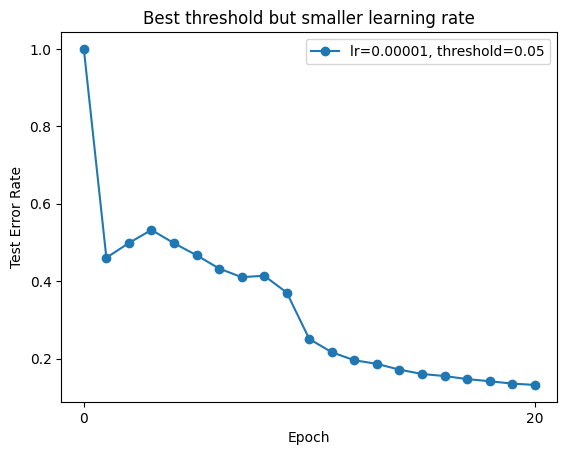

In [4]:
if __name__ == "__main__":
    torch.manual_seed(1000)
    torch.cuda.empty_cache()
    alice = NetOfLain([784, 500, 500])
    err_recorder = []
    err_recorder.append(1.0)
    print("STDP: ON")
    for epo in range(1):
      print("Epoch:", epo+1)
      torch.cuda.empty_cache()
      alice.network_train_layers(train_data_loader, epo)
      countT = 0.
      lossT = 0.
      for test_x, test_y in test_data_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        lossT += 1.0 - alice.network_predict(test_x).eq(test_y).float().mean().item()
        countT += 1
        for lain_layer in alice.lain_layers:
          functional.reset_net(lain_layer.single_net)
      print('test error:', lossT / countT)
      err_recorder.append(lossT / countT)

    alicelr2 = NetOfLain([784, 500, 500])
    alicelr2.lain_layers[0].learning_rate = 0.001
    err_recorder2 = []
    err_recorder2.append(1.0)
    for epo in range(2):
      print("Epoch:", epo+1)
      torch.cuda.empty_cache()
      alicelr2.network_train_layers(train_data_loader, epo)
      countT = 0.
      lossT = 0.
      for test_x, test_y in test_data_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        lossT += 1.0 - alicelr2.network_predict(test_x).eq(test_y).float().mean().item()
        countT += 1
        for lain_layer in alicelr2.lain_layers:
          functional.reset_net(lain_layer.single_net)
      print('test error:', lossT / countT)
      err_recorder2.append(lossT / countT)

    alicesh2 = NetOfLain([784, 500, 500])
    alicesh2.lain_layers[0].threshold_pos = 2
    alicesh2.lain_layers[0].threshold_neg = 2
    err_recorder3 = []
    err_recorder3.append(1.0)
    for epo in range(2):
      print("Epoch:", epo+1)
      torch.cuda.empty_cache()
      alicesh2.network_train_layers(train_data_loader, epo)
      countT = 0.
      lossT = 0.
      for test_x, test_y in test_data_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        lossT += 1.0 - alicesh2.network_predict(test_x).eq(test_y).float().mean().item()
        countT += 1
        for lain_layer in alicesh2.lain_layers:
          functional.reset_net(lain_layer.single_net)
      print('test error:', lossT / countT)
      err_recorder3.append(lossT / countT)

    plt.plot(err_recorder, label='lr=0.0003, threshold=0.05', marker='o')
    plt.plot(err_recorder2, label='lr=0.001, threshold=0.05', marker='x')
    plt.plot(err_recorder3, label='lr=0.0003, threshold=2', marker='D')
    plt.title("Comparison: learning rate and threshold")
    plt.xlabel("Epoch")
    plt.ylabel("Test Error Rate")
    plt.xticks((0,3))
    plt.legend()
    plt.show()

    alicelr3 = NetOfLain([784, 500, 500])
    alicelr3.lain_layers[0].learning_rate = 0.00001
    err_recorder4 = []
    err_recorder4.append(1.0)
    for epo in range(20):
      print("Epoch:", epo+1)
      torch.cuda.empty_cache()
      alicelr3.network_train_layers(train_data_loader, epo)
      countT = 0.
      lossT = 0.
      for test_x, test_y in test_data_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        lossT += 1.0 - alicelr3.network_predict(test_x).eq(test_y).float().mean().item()
        countT += 1
        for lain_layer in alicelr3.lain_layers:
          functional.reset_net(lain_layer.single_net)
      print('test error:', lossT / countT)
      err_recorder4.append(lossT / countT)
    plt.plot(err_recorder4, label='lr=0.00001, threshold=0.05', marker='o')
    plt.title("Best threshold but smaller learning rate")
    plt.xlabel("Epoch")
    plt.ylabel("Test Error Rate")
    plt.xticks((0,20))
    plt.legend()
    plt.show()